# SAP HANA Integration using pyodbc

In [1]:
#imoporting the required libraries
import pandas as pd
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
%matplotlib inline
import sklearn
import datetime
warnings.filterwarnings('ignore')


# Establish conncetion between SAP HANA DB from python using ODBC connector

In [2]:
conn = pyodbc.connect('DRIVER={HDBODBC};SERVERNODE=ip adress:30115;SERVERDB=HD1;UID=useridJ;PWD=Bpasssword') #Open connection to SAP HANA  

In [3]:
# check if table has entries
cursor = conn.cursor() 
sql_query1 = 'SELECT count(*) FROM SCHEMA.STARTUP_DATA2'
dcount = pd.read_sql(sql_query1, conn)
dcount
print ('Table exists and contains', dcount.head(1), 'records' ) 

Table exists and contains    COUNT(*)
0        56 records


In [137]:
#querying the sap hana db data and store in dataframe
sql_query2 = 'SELECT * FROM SCHEMA.STARTUP_DATA2'
df = pd.read_sql(sql_query2, conn)
df.info()
df.describe().T
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 8 columns):
ID                  56 non-null int64
STATE               56 non-null object
RNDSPEND            54 non-null float64
ADMINISTRATION      56 non-null float64
MARKETINGSPEND      56 non-null float64
PROFIT              56 non-null float64
LOADDATE            56 non-null object
PREDICTED_PROFIT    0 non-null object
dtypes: float64(4), int64(1), object(3)
memory usage: 3.6+ KB


Index(['ID', 'STATE', 'RNDSPEND', 'ADMINISTRATION', 'MARKETINGSPEND', 'PROFIT',
       'LOADDATE', 'PREDICTED_PROFIT'],
      dtype='object')

In [ ]:
#'ID', 'STATE', 'RNDSPEND', 'ADMINISTRATION', 'MARKETINGSPEND', 'PROFIT','LOADDATE', 'PREDICTED_PROFIT'

In [138]:
df.shape
df.head()
df1 = df
df1.tail(10)

,ID,STATE,RNDSPEND,ADMINISTRATION,MARKETINGSPEND,PROFIT,LOADDATE,PREDICTED_PROFIT
46,98,Florida,1315.46,115816.21,297114.46,49490.75,2019-06-07,None
47,99,New York,542.05,51743.15,0.00,35673.41,2019-06-07,None
48,100,California,NaN,135426.92,0.00,42559.73,2019-06-07,None
49,101,California,NaN,116983.80,45173.06,14681.40,2019-06-07,None
50,2,Texas,24177.74,174806.14,26334.72,63200.33,2019-06-07,None
51,3,Chicago,2000.23,122153.04,1803.93,60926.08,2019-06-07,None
52,4,Boston,1315.46,115816.21,297114.46,49490.75,2019-06-07,None
53,6,Houston,1515.46,118816.21,257114.46,43490.75,2019-06-07,None
54,5,Denver,1415.46,11816.21,27114.46,4490.75,2019-06-07,None
55,1,New York,155349.20,146897.80,471904.10,192561.83,2019-06-07,None


In [46]:
#USING GROUP BY CLAUSE TO ANALYZE THE DATA
df1.groupby('STATE').agg({'PROFIT':['sum','mean','count','max','std','min','median']}).round(0)

PROFIT                                                      
                  sum      mean count       max      std      min    median
STATE                                                                      
Boston        49491.0   49491.0     1   49491.0      NaN  49491.0   49491.0
California  1766388.0  103905.0    17  191792.0  44446.0  14681.0   97428.0
Chicago       60926.0   60926.0     1   60926.0      NaN  60926.0   60926.0
Denver         4491.0    4491.0     1    4491.0      NaN   4491.0    4491.0
Florida     1900384.0  118774.0    16  191050.0  35605.0  49491.0  109543.0
Houston       43491.0   43491.0     1   43491.0      NaN  43491.0   43491.0
New York    2126421.0  118135.0    18  192562.0  44022.0  35673.0  109933.0
Texas         63200.0   63200.0     1   63200.0      NaN  63200.0   63200.0

In [47]:
# Functions to address missing data
# Explore features
def feat_explore(column):
    return df[column].value_counts()
feat_explore('STATE')

New York      18
California    17
Florida       16
Texas          1
Chicago        1
Boston         1
Denver         1
Houston        1
Name: STATE, dtype: int64

In [139]:
df.isnull().any()

ID                  False
STATE               False
RNDSPEND             True
ADMINISTRATION      False
MARKETINGSPEND      False
PROFIT              False
LOADDATE            False
PREDICTED_PROFIT     True
dtype: bool

,Total,Percent
RNDSPEND,2,3.571429


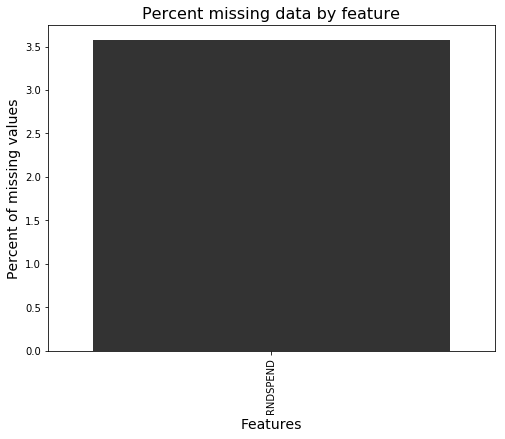

In [70]:
#to see the missing values
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="black",alpha=0.8)
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Percent of missing values', fontsize=14)
    plt.title('Percent missing data by feature', fontsize=16)
    return ms

missingdata(df1)
# rnd spend has two null values

In [27]:
#fill the null values since the rndspend is continous value,we will fill with mean value
df['RNDSPEND'].mean()
df['RNDSPEND'].median()

69820.065

In [28]:
df['STATE'].mode()

0    New York
dtype: object

In [140]:
df1['RNDSPEND'] = df1['RNDSPEND'].fillna(df1['RNDSPEND'].median())

In [141]:
df.isnull().any()

ID                  False
STATE               False
RNDSPEND            False
ADMINISTRATION      False
MARKETINGSPEND      False
PROFIT              False
LOADDATE            False
PREDICTED_PROFIT     True
dtype: bool

In [142]:
#adding the state code to data frame using mapping function
df1['STATECODE'] = df1['STATE'].map({'New York':'NY','California':'CA','Florida':'FL','Texas':'TX',
                                   'Chicago':'IL','Boston': 'MA','Houston':'TX','Denver':'CO'})


In [143]:
df1.head()

,ID,STATE,RNDSPEND,ADMINISTRATION,MARKETINGSPEND,PROFIT,LOADDATE,PREDICTED_PROFIT,STATECODE
0,52,New York,165349.20,136897.80,471784.10,192261.83,2019-06-07,None,NY
1,53,California,162597.70,151377.59,443898.53,191792.06,2019-06-07,None,CA
2,54,Florida,153441.51,101145.55,407934.54,191050.39,2019-06-07,None,FL
3,55,New York,144372.41,118671.85,383199.62,182901.99,2019-06-07,None,NY
4,56,Florida,142107.34,91391.77,366168.42,166187.94,2019-06-07,None,FL


In [134]:
df2 = df1
#df2 = df2.drop('PREDICTED_PROFIT',axis=1,inplace=True)

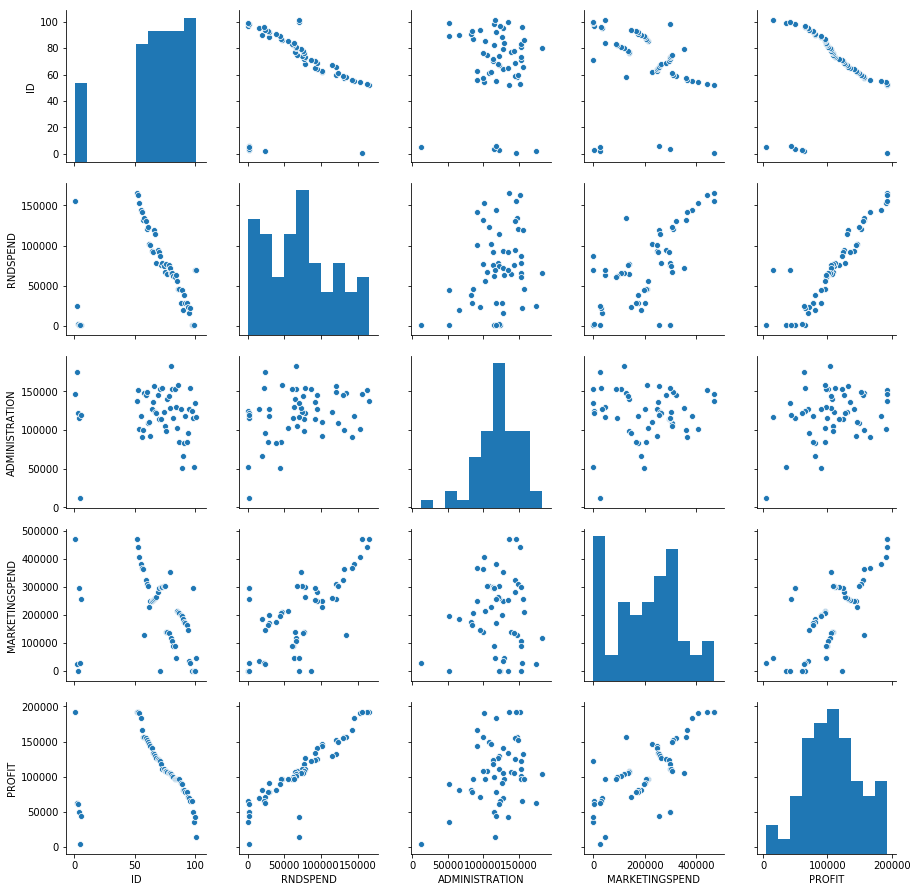

In [135]:
sns.pairplot(df2)

In [33]:
# Statistical Summary
print("profit Statistical Summary:\n")
print(df1['PROFIT'].describe())
print("Median of Profit:", df1['PROFIT'].median(axis = 0))
print('Skewness:',df1['PROFIT'].skew())
skew = df1['PROFIT'].skew()


profit Statistical Summary:

count        56.000000
mean     107407.008036
std       44734.123711
min        4490.750000
25%       78129.640000
50%      105370.925000
75%      136126.892500
max      192561.830000
Name: PROFIT, dtype: float64
Median of Profit: 105370.92499999999
Skewness: 0.013005212840810626


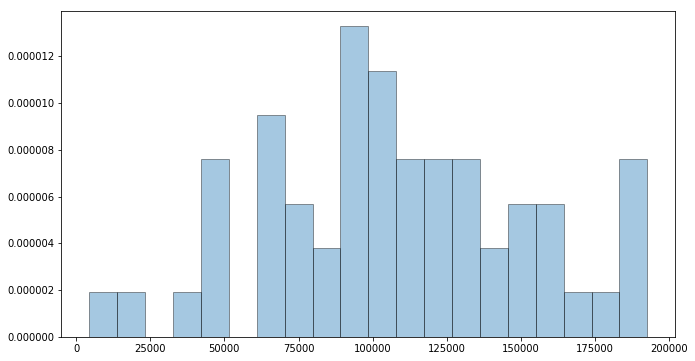

In [34]:
# mean distribution
mu = df1['PROFIT'].mean()
# std distribution
sigma = df1['PROFIT'].std()
num_bins = 20
# Histogram of SalesPrice
plt.figure(figsize=(11, 6))
n, bins, patches = plt.hist(df1['PROFIT'], num_bins, normed=1,edgecolor = 'black', lw = 1, alpha = .40)


In [35]:
df1.corr()

,ID,RNDSPEND,ADMINISTRATION,MARKETINGSPEND,PROFIT,PREDICTED_PROFIT
ID,1.000000,-0.164752,-0.051503,-0.274938,-0.178327,-0.186213
RNDSPEND,-0.164752,1.000000,0.292264,0.660918,0.913698,0.946770
ADMINISTRATION,-0.051503,0.292264,1.000000,0.047756,0.293657,0.281847
MARKETINGSPEND,-0.274938,0.660918,0.047756,1.000000,0.727559,0.738008
PROFIT,-0.178327,0.913698,0.293657,0.727559,1.000000,0.992440
PREDICTED_PROFIT,-0.186213,0.946770,0.281847,0.738008,0.992440,1.000000


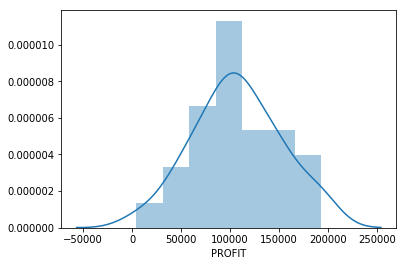

In [36]:
sns.distplot(df1['PROFIT'])

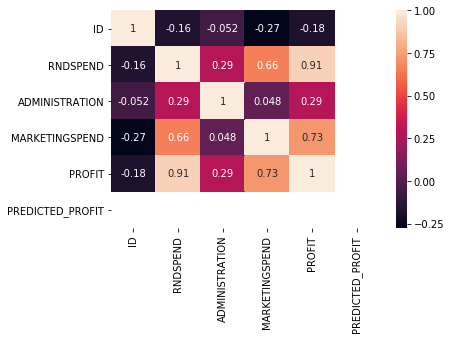

In [75]:
sns.heatmap(df.corr(),annot=True)

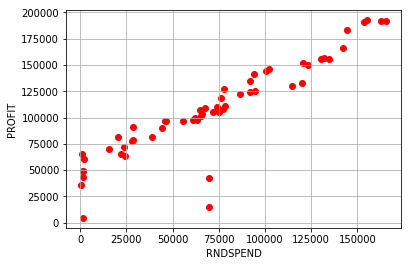

In [44]:
# to find the relation ship between the variables
plt.scatter(df['RNDSPEND'], df['PROFIT'], color='red')
plt.grid(True)
plt.xlabel('RNDSPEND')
plt.ylabel('PROFIT')
plt.show()


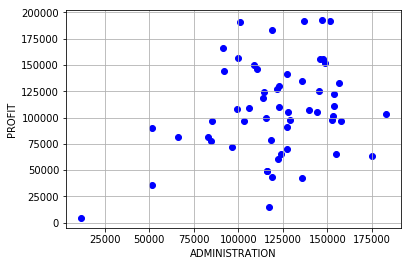

In [45]:
plt.scatter(df['ADMINISTRATION'], df['PROFIT'], color='blue')
plt.grid(True)
plt.xlabel('ADMINISTRATION')
plt.ylabel('PROFIT')
plt.show()

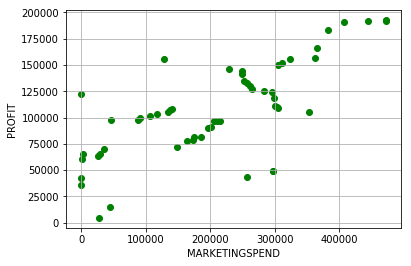

In [46]:
plt.scatter(df['MARKETINGSPEND'], df['PROFIT'], color='green')
plt.grid(True)
plt.xlabel('MARKETINGSPEND')
plt.ylabel('PROFIT')
plt.show()

#Train Test Split
#Now let's split the data into a training set and a testing set. We will train out model on the training set and then use the #test set to evaluate the model.

In [111]:
#Feature selection , i am using 'RNDSPEND', 'ADMINISTRATION', 'MARKETINGSPEND' as independant variables to predict profit
X = df1[['RNDSPEND', 'ADMINISTRATION', 'MARKETINGSPEND']]
Y = df1['PROFIT']

In [14]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=101)

In [112]:
#using random forest
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X, Y);
y_pred = rf.predict(X)
df4 = pd.DataFrame({'Actual':  Y, 'Predicted': y_pred,'Diff': (Y-y_pred)})
df4.head()

,Actual,Predicted,Diff
0,192261.83,191861.15998,400.67002
1,191792.06,191651.73247,140.32753
2,191050.39,188062.37148,2988.01852
3,182901.99,177568.28812,5333.70188
4,166187.94,167664.97222,-1477.03222


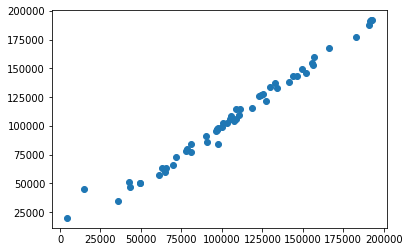

In [113]:
#LET US PLOT THE PREDICTED VS ACTUAL
plt.scatter(Y,y_pred)

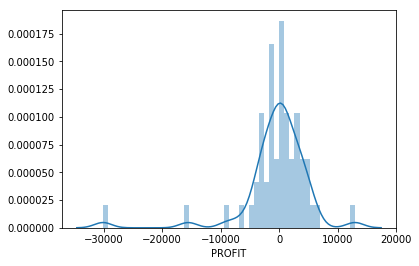

In [101]:
#Residual Histogram
sns.distplot((Y-y_pred),bins=50);

In [78]:
# Calculate the absolute errors
errors = abs(y_pred - Y)
# Print out the mean absolute error (mae)
mae = round(np.mean(errors), 2)
print('Mean Absolute Error:', round(np.mean(errors), 2))
mse = round(mean_squared_error(Y, y_pred),2)
rmse = round(np.sqrt(mse),2)
print('mean squared error --> ', mse, 'RMSE is ', rmse)
print('R²: %.2f' % r2_score(Y, y_pred))
r_squared = round(r2_score(Y, y_pred),3)
Y.mean()
print (rmse - Y.mean())

Mean Absolute Error: 3354.15
mean squared error -->  32419562.39 RMSE is  5693.82
R²: 0.98
-101713.1880357143


In [96]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * np.mean(errors / Y)
mape
# Calculate and display accuracy
accuracy = round((100 - np.mean(mape)),2)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 87.39 %.


In [114]:
#
type(y_pred)
ser = pd.Series(y_pred)
ser

0     191861.15998
1     191651.73247
2     188062.37148
3     177568.28812
4     167664.97222
5     159542.32782
6     153186.97154
7     154886.88821
8     146066.23027
9     149227.84696
10    143796.03695
11    143352.62413
12    138055.20062
13    133402.33335
14    137468.49384
15    133949.03778
16    122070.20922
17    127912.85121
18    127225.91779
19    125971.53265
20    115379.51002
21    114806.85105
22    109224.64172
23    106477.01012
24    115065.07337
25    104704.44576
26    109062.03672
27    106207.81613
28    102910.62843
29    102277.92013
30     98891.83598
31     97964.82632
32     84492.57061
33     97307.91436
34     96148.67099
35     95466.16609
36     86245.49328
37     91186.78460
38     77599.59829
39     84086.34387
40     79597.92292
41     78420.18459
42     73097.70772
43     65637.32828
44     63114.71542
45     59762.27412
46     50739.93520
47     35128.00775
48     51445.56977
49     44799.80171
50     63019.20567
51     57678.58617
52     50739

In [107]:
ser = pd.Series(y_pred)
ser

0     191861.15998
1     191651.73247
2     188062.37148
3     177568.28812
4     167664.97222
5     159542.32782
6     153186.97154
7     154886.88821
8     146066.23027
9     149227.84696
10    143796.03695
11    143352.62413
12    138055.20062
13    133402.33335
14    137468.49384
15    133949.03778
16    122070.20922
17    127912.85121
18    127225.91779
19    125971.53265
20    115379.51002
21    114806.85105
22    109224.64172
23    106477.01012
24    115065.07337
25    104704.44576
26    109062.03672
27    106207.81613
28    102910.62843
29    102277.92013
30     98891.83598
31     97964.82632
32     84492.57061
33     97307.91436
34     96148.67099
35     95466.16609
36     86245.49328
37     91186.78460
38     77599.59829
39     84086.34387
40     79597.92292
41     78420.18459
42     73097.70772
43     65637.32828
44     63114.71542
45     59762.27412
46     50739.93520
47     35128.00775
48     51445.56977
49     44799.80171
50     63019.20567
51     57678.58617
52     50739

In [144]:
df1['PREDICTED_PROFIT'] = df1['PREDICTED_PROFIT'].fillna(ser)
df1.head(55)

,ID,STATE,RNDSPEND,ADMINISTRATION,MARKETINGSPEND,PROFIT,LOADDATE,PREDICTED_PROFIT,STATECODE
0,52,New York,165349.200,136897.80,471784.10,192261.83,2019-06-07,191861.15998,NY
1,53,California,162597.700,151377.59,443898.53,191792.06,2019-06-07,191651.73247,CA
2,54,Florida,153441.510,101145.55,407934.54,191050.39,2019-06-07,188062.37148,FL
3,55,New York,144372.410,118671.85,383199.62,182901.99,2019-06-07,177568.28812,NY
4,56,Florida,142107.340,91391.77,366168.42,166187.94,2019-06-07,167664.97222,FL
5,57,New York,131876.900,99814.71,362861.36,156991.12,2019-06-07,159542.32782,NY
6,58,California,134615.460,147198.87,127716.82,156122.51,2019-06-07,153186.97154,CA
7,59,Florida,130298.130,145530.06,323876.68,155752.60,2019-06-07,154886.88821,FL
8,60,New York,120542.520,148718.95,311613.29,152211.77,2019-06-07,146066.23027,NY
9,61,California,123334.880,108679.17,304981.62,149759.96,2019-06-07,149227.84696,CA


In [81]:
# prediction for new values
New_RNDSPEND = 10000
New_ADMINISTRATION =  230000
New_MARKETINGSPEND = 34000
print ('Predicted PROFIT: \n', rf.predict([[New_RNDSPEND ,New_ADMINISTRATION,New_MARKETINGSPEND]]))

Predicted PROFIT: 
 [64965.9129]


In [82]:
param = 'MAE = ', mae,'MSE = ', mse,'RMSE = ',rmse,'RSQUARED = ', r_squared, 'ACCURACY = ', accuracy
print(param)


('MAE = ', 3354.15, 'MSE = ', 32419562.39, 'RMSE = ', 5693.82, 'RSQUARED = ', 0.984, 'ACCURACY = ', 87.39)


In [83]:
currentDT = datetime.datetime.now()
date_today = datetime.date.today()
time_now = currentDT.strftime("%H:%M:%S")
print(date_today, time_now)

2019-06-28 10:20:08


In [84]:
# saving the metrics/performance of model details in the table
cursor.execute("INSERT INTO SCHEMA.ML_METRICS VALUES(?,?,?,?,?,?,?,?,?,?)", (date_today,time_now,'Random forest regression',mae,mse,rmse,r_squared,mape,accuracy,'First run')) #Save the content to the table  
cursor.execute("COMMIT") #Save the content to the 
print ('1 records inserted into table') 


1 records inserted into table


In [85]:
#retrieving the data from ml metrics table
sql_query2 = 'SELECT * FROM SCHEMA.ML_METRICS'
df = pd.read_sql(sql_query2, conn)
df


,UPDATE_DATE,UPDATE_TIME,MODELNAME,MAE,MSE,RMSE,R_SQUARED,MAPE,ACCURACY,COMMENTS
0,2019-03-16,10:51:49,Linear regression,1.20,2.20,3.00,4.90,5.00,6.00,good
1,2019-06-16,10:51:49,Linearregression,1.20,2.20,3.00,4.90,5.00,6.00,good
2,2019-06-07,15:58:32,Lin reg,3626.76,38843398.90,6232.45,0.97,5.50,92.17,First run
3,2019-06-10,21:43:58,Lin reg,3626.76,38843398.90,6232.45,0.97,7.82,92.17,First run
4,2019-06-21,13:05:01,Random forest regression,3354.15,32419562.39,5693.82,0.98,12.61,87.39,First run
5,2019-06-28,10:20:08,Random forest regression,3354.15,32419562.39,5693.82,0.98,12.61,87.39,First run


In [145]:
#
for index,row in df1.iterrows():
    values = (round(row['PREDICTED_PROFIT'],2),row['ID'])
    print(values)

(191861.16, 52)
(191651.73, 53)
(188062.37, 54)
(177568.29, 55)
(167664.97, 56)
(159542.33, 57)
(153186.97, 58)
(154886.89, 59)
(146066.23, 60)
(149227.85, 61)
(143796.04, 62)
(143352.62, 63)
(138055.2, 64)
(133402.33, 65)
(137468.49, 66)
(133949.04, 67)
(122070.21, 68)
(127912.85, 69)
(127225.92, 70)
(125971.53, 71)
(115379.51, 72)
(114806.85, 73)
(109224.64, 74)
(106477.01, 75)
(115065.07, 76)
(104704.45, 77)
(109062.04, 78)
(106207.82, 79)
(102910.63, 80)
(102277.92, 81)
(98891.84, 82)
(97964.83, 83)
(84492.57, 84)
(97307.91, 85)
(96148.67, 86)
(95466.17, 87)
(86245.49, 88)
(91186.78, 89)
(77599.6, 90)
(84086.34, 91)
(79597.92, 92)
(78420.18, 93)
(73097.71, 94)
(65637.33, 95)
(63114.72, 96)
(59762.27, 97)
(50739.94, 98)
(35128.01, 99)
(51445.57, 100)
(44799.8, 101)
(63019.21, 2)
(57678.59, 3)
(50739.94, 4)
(46787.97, 6)
(20048.31, 5)
(191903.04, 1)


In [146]:
#updating the predicted value to actual HANA Table
#updating the predicted value to actual HANA Table
for index,row in df1.iterrows():
    values = (row['PREDICTED_PROFIT'],row['ID'])
    cursor.execute("UPDATE SCHEMA.STARTUP_DATA2 set PREDICTED_PROFIT=? where ID =?", values)
    cursor.execute("COMMIT")

In [147]:
#retrieving the data from START UP Base table
sql_query2 = 'SELECT * FROM SCHEMA.STARTUP_DATA2'
df = pd.read_sql(sql_query2, conn)
df

,ID,STATE,RNDSPEND,ADMINISTRATION,MARKETINGSPEND,PROFIT,LOADDATE,PREDICTED_PROFIT
0,52,New York,165349.20,136897.80,471784.10,192261.83,2019-06-07,191861.15
1,53,California,162597.70,151377.59,443898.53,191792.06,2019-06-07,191651.73
2,54,Florida,153441.51,101145.55,407934.54,191050.39,2019-06-07,188062.37
3,55,New York,144372.41,118671.85,383199.62,182901.99,2019-06-07,177568.28
4,56,Florida,142107.34,91391.77,366168.42,166187.94,2019-06-07,167664.97
5,57,New York,131876.90,99814.71,362861.36,156991.12,2019-06-07,159542.32
6,58,California,134615.46,147198.87,127716.82,156122.51,2019-06-07,153186.97
7,59,Florida,130298.13,145530.06,323876.68,155752.60,2019-06-07,154886.88
8,60,New York,120542.52,148718.95,311613.29,152211.77,2019-06-07,146066.23
9,61,California,123334.88,108679.17,304981.62,149759.96,2019-06-07,149227.84
